In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import sympy as sp

from macrosim.SeriesAccessor import SeriesAccessor
from macrosim.EqSearch import EqSearch
from macrosim.SimEngine import SimEngine

import corner

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
fred = SeriesAccessor(key_path='../fred_key.env', key_name='fred_key')

In [3]:
start = dt.datetime.fromisoformat("2000-01-01")
end = dt.datetime.fromisoformat("2024-01-01")

In [4]:
df = fred.get_series(series_ids=['CPIAUCSL', 'A264RX1A020NBEA', 'PSAVERT', 'M2REAL', 'GDPC1'], date_range=(start, end), reindex_freq='QS', series_alias=['CPI', 'CAPINV','SRATE', 'M_2','RGDP'])

In [5]:
df = fred.fill(
    df,
    [None, 'ffill', None, None, None]
)
df

,CPI,CAPINV,SRATE,M_2,RGDP
2000-01-01,169.300,385.205,4.5,2757.0,13878.147
2000-04-01,170.900,385.205,4.3,2789.8,14130.908
2000-07-01,172.700,385.205,4.7,2774.3,14145.312
2000-10-01,173.900,385.205,4.3,2801.3,14229.765
2001-01-01,175.600,392.441,4.5,2835.1,14183.120
...,...,...,...,...,...
2023-01-01,300.456,633.170,4.2,7057.6,22403.435
2023-04-01,302.858,633.170,5.0,6844.8,22539.418
2023-07-01,304.615,633.170,4.6,6819.2,22780.933
2023-10-01,307.653,633.170,4.5,6724.2,22960.600


In [6]:
#corner.corner(df, labels=df.columns, bins=10)

In [7]:
eqsr = EqSearch(
    X=df.drop(columns=['RGDP']),
    y=df['RGDP']
)

In [8]:
eqsr.distil_split()

RandomForest Score at Distillation: 0.9742405487519203


In [9]:
eqsr.search(
    constraints={'sqrt': 2, 'inv':3}
)

Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 2.480e+05
Progress: 1017 / 9300 total iterations (10.935%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.330e+06  1.594e+01  y = 17892
3           3.234e+05  1.487e+00  y = CPI * 78.67
5           2.220e+05  1.880e-01  y = (CPI * 69.787) - -2063.9
7           2.098e+05  2.836e-02  y = M_2 + ((CAPINV * 15.111) - -5588.5)
8           1.438e+05  3.777e-01  y = ((CPI * 6.1971) + 717.9) * log(M_2)
11          1.433e+05  1.162e-03  y = (((CPI * 61.93) + (M_2 - -7058.8)) ^ 0.96417) + 1.8256
12          1.426e+05  4.994e-03  y = log(M_2) * ((6.1515 * (117.59 + CPI)) - (0.065953 - SR...
                                      ATE))
14          1.315e+05  4.045e-02  y = ((M_2 + (((log(M_2) * CPI) + -1047.2) * 20.937)) ^ 0.8...
                            

[ Info: Final population:
[ Info: Results saved to:


Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [10]:
act = df['RGDP']
pred_values = [eqsr.eq.subs(row[1].to_dict()).evalf() for row in df.drop('RGDP', axis=1).iterrows()]
pred = pd.Series(pred_values, index=df.index)

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

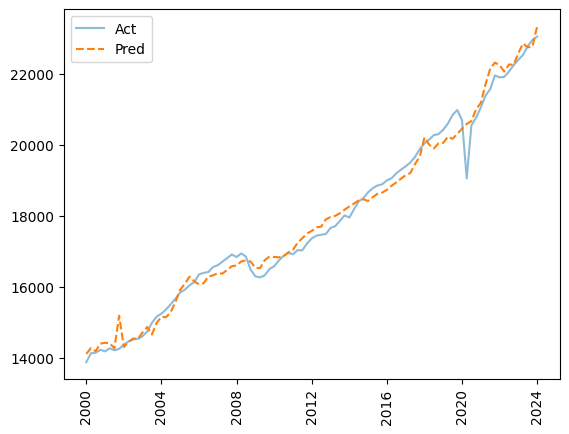

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [11]:
plt.plot(act, label='Act', alpha=0.5)
plt.plot(pred, label='Pred', linestyle='--')

plt.xticks(rotation=90)

plt.legend()
plt.show()

In [12]:
eqsr.eq.evalf(4)

M_2**0.5 + 1.191*M_2 - SRATE*(-90.65*CPI + M_2 + 1.655e+4)/(-CAPINV/(CAPINV + 1.801*M_2 - 1.053e+4) + 10.0) + 1.254e+4

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [13]:
engine = SimEngine(
    eq=eqsr.eq,
    init_params={
        'CPI': (160, lambda x: x*.999),
        'CAPINV': (390, lambda x: x*1.05),
        'SRATE': (4.5, lambda x: x*1.01),
        'M_2': (2800, lambda x: x*1.01),
    }
)

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [14]:
for _ in range(100):
    next(engine._simulate())
engine.get_history()

,CPI,CAPINV,SRATE,M_2,output
step,,,,,
0,161.824870,408.084519,4.618594,2935.678211,13767.704881
1,160.716696,425.980619,4.848947,3021.921764,13888.870884
2,158.671557,453.346552,4.840697,3016.604160,13794.279899
3,159.471738,453.245180,4.678271,3003.941179,13707.167580
4,155.278356,479.646255,4.617793,2926.858040,13814.672994
...,...,...,...,...,...
95,149.066581,41742.946729,11.818129,7299.044422,7639.753907
96,146.091310,43994.888410,12.038293,7717.814787,7840.464133
97,149.412964,45528.386517,11.885588,7890.855597,7195.426579


Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

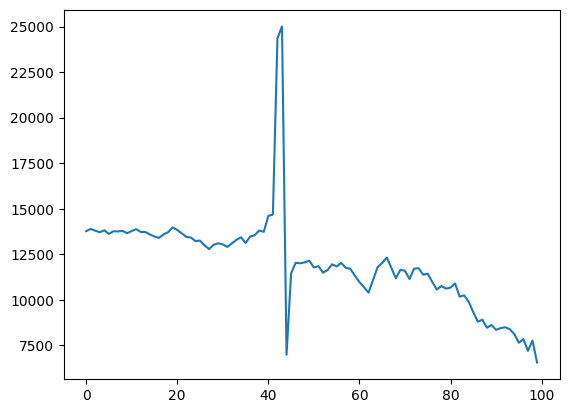

In [15]:
plt.plot(engine.get_history()['output'])

In [16]:
from macrosim.GrowthPatternDetector import GrowthPatternDetector
gpd = GrowthPatternDetector()

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [17]:
gpd.fit_pattern(df)

{'CPI': (<function macrosim.GrowthPatternDetector.GrowthPatternDetector.fit_pattern.<locals>.<lambda>(x, func=<function GrowthPatternDetector._linear at 0x314fbf240>, params=array([  1.23741736, 166.1697558 ]))>,
  np.float64(53.59445147888025)),
 'CAPINV': (<function macrosim.GrowthPatternDetector.GrowthPatternDetector.fit_pattern.<locals>.<lambda>(x, func=<function GrowthPatternDetector._linear at 0x314fbf240>, params=array([  2.56867989, 381.25804637]))>,
  np.float64(82.11306651057069)),
 'SRATE': (<function macrosim.GrowthPatternDetector.GrowthPatternDetector.fit_pattern.<locals>.<lambda>(x, func=<function GrowthPatternDetector._linear at 0x314fbf240>, params=array([0.04895066, 3.36636598]))>,
  np.float64(12.276671006483156)),
 'M_2': (<function macrosim.GrowthPatternDetector.GrowthPatternDetector.fit_pattern.<locals>.<lambda>(x, func=<function GrowthPatternDetector._linear at 0x314fbf240>, params=array([  49.23831922, 2227.90998738]))>,
  np.float64(159323.98390842543)),
 'RGDP'

Error in callback _flush_stdio (for post_execute):


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data